In [1]:
from dask.distributed import Client, LocalCluster
import logging

cluster = LocalCluster(
    n_workers=28,
    threads_per_worker=8,
    silence_logs=logging.DEBUG
)

client = Client(cluster, heartbeat_interval=10000)
print(client.dashboard_link)

distributed.scheduler - INFO - Clear task state
distributed.scheduler - INFO -   Scheduler at:     tcp://127.0.0.1:42889
distributed.scheduler - INFO -   dashboard at:            127.0.0.1:8787
distributed.nanny - INFO -         Start Nanny at: 'tcp://127.0.0.1:46873'
distributed.nanny - INFO -         Start Nanny at: 'tcp://127.0.0.1:38117'
distributed.nanny - INFO -         Start Nanny at: 'tcp://127.0.0.1:33769'
distributed.nanny - INFO -         Start Nanny at: 'tcp://127.0.0.1:37873'
distributed.nanny - INFO -         Start Nanny at: 'tcp://127.0.0.1:41291'
distributed.nanny - INFO -         Start Nanny at: 'tcp://127.0.0.1:37817'
distributed.nanny - INFO -         Start Nanny at: 'tcp://127.0.0.1:33163'
distributed.nanny - INFO -         Start Nanny at: 'tcp://127.0.0.1:46737'
distributed.nanny - INFO -         Start Nanny at: 'tcp://127.0.0.1:33709'
distributed.nanny - INFO -         Start Nanny at: 'tcp://127.0.0.1:39109'
distributed.nanny - INFO -         Start Nanny at: 'tcp:

http://127.0.0.1:8787/status


In [2]:
import afqinsight as afqi
import joblib
import matplotlib.pyplot as plt
import numpy as np
import os.path as op
import pandas as pd
import pickle
import seaborn as sns

from datetime import datetime

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegressionCV

print(afqi.__version__)

0.2.9.dev460469908


In [3]:
X, y, groups, columns, subjects, classes = afqi.load_afq_data(
    "../data/raw/als_data",
    target_cols=["class"],
    label_encode_cols=["class"],
)

In [4]:
label_sets = afqi.multicol2sets(pd.MultiIndex.from_tuples(columns, names=["metric", "tractID", "nodeID"]))

In [5]:
X_md_fa = afqi.select_groups(X, [["fa"], ["md"]], label_sets)

In [6]:
groups_md_fa = groups[:40]

In [18]:
def get_cv_results(n_repeats=5, n_splits=10,
                   power_transformer=False, 
                   shuffle=False,
                   ensembler=None,
                   n_estimators=10):
    if shuffle:
        rng = np.random.default_rng()
        y_fit = rng.permutation(y)
    else:
        y_fit = np.copy(y)

    cv = RepeatedStratifiedKFold(
        n_splits=n_splits,
        n_repeats=n_repeats,
        random_state=1729
    )

    cv_results = {}
    pipe = afqi.pipeline.make_base_afq_pipeline(
        imputer_kwargs={"strategy": "median"},
        power_transformer=power_transformer,
        scaler="standard",
        estimator=LogisticRegressionCV,
        estimator_kwargs={
            "verbose": 0,
            "Cs": 200,
            "penalty": "l1",
            "cv": 3,
            "n_jobs": 28,
            "solver": "saga",
            "max_iter": 1000,
        },
        ensemble_meta_estimator=ensembler,
        ensemble_meta_estimator_kwargs={
            "n_estimators": n_estimators,
            "n_jobs": 1,
            "oob_score": True,
            "random_state": 1729,
        },
    )

    for cv_idx, (train_idx, test_idx) in enumerate(cv.split(X_md_fa, y_fit)):
        start = datetime.now()

        X_train, X_test = X_md_fa[train_idx], X_md_fa[test_idx]
        y_train, y_test = y_fit[train_idx], y_fit[test_idx]

        with joblib.parallel_backend("dask"):
            pipe.fit(X_train, y_train)

        cv_results[cv_idx] = {
            "pipeline": pipe,
            "train_idx": train_idx,
            "test_idx": test_idx,
            "y_prob": pipe.predict_proba(X_test)[:, 1],
            "y_pred": pipe.predict(X_test),
            "y_true": y_test,
            "test_accuracy": accuracy_score(y_test, pipe.predict(X_test)),
            "train_accuracy": accuracy_score(y_train, pipe.predict(X_train))
        }
        
        print(f"CV index [{cv_idx:3d}], Elapsed time: ", datetime.now() - start)
        
    return cv_results, y_fit

In [19]:
# results = {}
results["no_power_transform"] = get_cv_results(
    n_splits=10, n_repeats=5, power_transformer=False, shuffle=False
)
# results["power_transform"] = get_cv_results(
#     n_splits=10, n_repeats=5, power_transformer=True, shuffle=False
# )
# results["shuffle_no_transform"] = get_cv_results(
#     n_splits=10, n_repeats=3, power_transformer=False, shuffle=True
# )
# results["shuffle_transform"] = get_cv_results(
#     n_splits=10, n_repeats=3, power_transformer=True, shuffle=True
# )

# with open("als_classify_lasso.pkl", "rb") as fp:
#     results = pickle.load(fp)

CV index [  0], Elapsed time:  0:00:15.492247


/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


CV index [  1], Elapsed time:  0:00:14.155092
CV index [  2], Elapsed time:  0:00:16.752468


/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


CV index [  3], Elapsed time:  0:00:18.292171


/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


CV index [  4], Elapsed time:  0:00:17.014838


/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


CV index [  5], Elapsed time:  0:00:15.337627
CV index [  6], Elapsed time:  0:00:18.502842
CV index [  7], Elapsed time:  0:00:14.809093


/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


CV index [  8], Elapsed time:  0:00:15.566926


/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


CV index [  9], Elapsed time:  0:00:15.987107


/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


CV index [ 10], Elapsed time:  0:00:16.809611
CV index [ 11], Elapsed time:  0:00:12.869801
CV index [ 12], Elapsed time:  0:00:15.910354


/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


CV index [ 13], Elapsed time:  0:00:15.557330
CV index [ 14], Elapsed time:  0:00:15.803153
CV index [ 15], Elapsed time:  0:00:18.337768
CV index [ 16], Elapsed time:  0:00:16.227859


/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


CV index [ 17], Elapsed time:  0:00:17.490000
CV index [ 18], Elapsed time:  0:00:13.650153


/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


CV index [ 19], Elapsed time:  0:00:17.989619
CV index [ 20], Elapsed time:  0:00:15.187211
CV index [ 21], Elapsed time:  0:00:16.516726
CV index [ 22], Elapsed time:  0:00:14.290799


/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


CV index [ 23], Elapsed time:  0:00:13.343382
CV index [ 24], Elapsed time:  0:00:16.031369


/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


CV index [ 25], Elapsed time:  0:00:16.589170
CV index [ 26], Elapsed time:  0:00:17.197662


/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


CV index [ 27], Elapsed time:  0:00:17.848605
CV index [ 28], Elapsed time:  0:00:15.043094


/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


CV index [ 29], Elapsed time:  0:00:15.657760


/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


CV index [ 30], Elapsed time:  0:00:15.131478


/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


CV index [ 31], Elapsed time:  0:00:15.218826


/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


CV index [ 32], Elapsed time:  0:00:15.308980
CV index [ 33], Elapsed time:  0:00:17.476120


/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


CV index [ 34], Elapsed time:  0:00:17.189544


/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


CV index [ 35], Elapsed time:  0:00:16.471300


/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


CV index [ 36], Elapsed time:  0:00:13.780965


/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


CV index [ 37], Elapsed time:  0:00:17.848679
CV index [ 38], Elapsed time:  0:00:15.016677


/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


CV index [ 39], Elapsed time:  0:00:17.770149


/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


CV index [ 40], Elapsed time:  0:00:16.567070


/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


CV index [ 41], Elapsed time:  0:00:13.354105


/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


CV index [ 42], Elapsed time:  0:00:16.267451


/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


CV index [ 43], Elapsed time:  0:00:16.072201


/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


CV index [ 44], Elapsed time:  0:00:16.877991
CV index [ 45], Elapsed time:  0:00:19.164572
CV index [ 46], Elapsed time:  0:00:15.598987


/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


CV index [ 47], Elapsed time:  0:00:15.885452


/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


CV index [ 48], Elapsed time:  0:00:16.315989
CV index [ 49], Elapsed time:  0:00:14.205428


In [20]:
with open("als_classify_lasso.pkl", "wb") as fp:
    pickle.dump(results, fp)

In [21]:
results.keys()

dict_keys(['shuffle_no_transform', 'no_power_transform'])

In [22]:
for key, res in results.items():
    test_accuracies = [cvr["test_accuracy"] for cvr in res[0].values()]
    train_accuracies = [cvr["train_accuracy"] for cvr in res[0].values()]
    print(key, "test", np.mean(test_accuracies))
    print(key, "train", np.mean(train_accuracies))

shuffle_no_transform test 0.39666666666666667
shuffle_no_transform train 0.8877026074700495
no_power_transform test 0.785
no_power_transform train 0.9870084566596193


In [23]:
import itertools

def mean_over_combinations(results):
    length = len(results)
    mean_results = {}
    for r in range(1, length + 1):
        mean_results[r] = [
            np.mean([res["yhat"].values for res in comb], axis=0)
            for comb in itertools.combinations(results, r=r)
        ]
        
    return mean_results

def accuracy_over_combinations(results):
    mean_results = mean_over_combinations(results)
    mean_accuracies = []
    for r in mean_results.keys():
        mean_accuracies += [
            {
                "n_repeats": r,
                "accuracy": accuracy_score(results[0]["class"].values, res > 0.5)
            } for res in mean_results[r]
        ]
        
    return pd.DataFrame(mean_accuracies)

def auc_over_combinations(results):
    mean_results = mean_over_combinations(results)
    mean_auc = []
    for r in mean_results.keys():
        mean_auc += [
            {
                "n_repeats": r,
                "auc": roc_auc_score(results[0]["class"].values, res)
            } for res in mean_results[r]
        ]
        
    return pd.DataFrame(mean_auc)

def get_accuracy_ensemble_dataframe(cv_results, y_true):    
    test_probs = {
        idx: pd.Series(
            data=cvr["y_prob"],
            index=cvr["test_idx"],
            name="yhat"
        )
        for idx, cvr in cv_results.items()
    }
    
    df_ytest = {
        idx: pd.DataFrame(test_probs[idx]).merge(
            pd.DataFrame(y, columns=["class"]),
            left_index=True,
            right_index=True,
            how="left"
        ) for idx in test_probs.keys()
    }
    
    acc_scores = [
        accuracy_score(_df["class"].values, _df["yhat"].values > 0.5)
        for _df in df_ytest.values()
    ]
    
    repeats = [
        pd.concat([df_ytest[i] for i in range(x * 10, (x + 1) * 10)]).sort_index()
        for x in range(len(cv_results) // 10)
    ]
    
    return accuracy_over_combinations(repeats)

In [24]:
df_accuracies = {
    key: get_accuracy_ensemble_dataframe(res[0], y)
    for key, res in results.items()
}

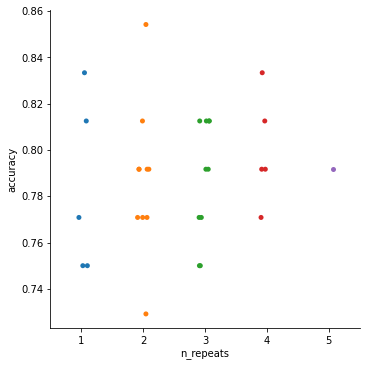

In [25]:
sns.catplot(x="n_repeats", y="accuracy", data=df_accuracies["no_power_transform"])

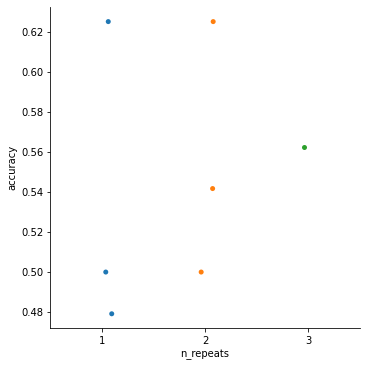

In [26]:
sns.catplot(x="n_repeats", y="accuracy", data=df_accuracies["shuffle_no_transform"])

In [ ]:
results["bagging_stratify"] = get_cv_results(
    n_splits=10, n_repeats=1, power_transformer=False,
    ensembler="serial-bagging", shuffle=False,
    n_estimators=20,
)
results["bagging_shuffle_stratify"] = get_cv_results(
    n_splits=10, n_repeats=1, power_transformer=False,
    ensembler="serial-bagging", shuffle=True
)

In [ ]:
for key, res in results.items():
    test_accuracies = [cvr["test_accuracy"] for cvr in res[0].values()]
    train_accuracies = [cvr["train_accuracy"] for cvr in res[0].values()]
    print(key, "test", np.mean(test_accuracies))
    print(key, "train", np.mean(train_accuracies))

In [ ]:
with open("als_classify.pkl", "wb") as fp:
    pickle.dump(results, fp)